## Momentum Trading Strategy: Achieving a 17% Annualized Return in the KL Stock Exchange
This notebook demonstrates a straightforward momentum-based strategy that achieves an annualized return of 17% in the KLSE market between 2010 and 2020. The strategy capitalizes on stocks breaking resistance levels.

Signal Criteria:

Buy Signal: 
1. Triggered when the stock price breaks above the 1-year Bollinger Band resistance level.

Trading Rules:
1. Only trade stocks with a 30-day average daily trading volume of more than MYR 500k.
2. Allocate MYR 5k per trade.
3. Start with an initial capital of MYR 10k.
4. Hold a maximum of 10 stocks at any given time.
5. Limit holding period to 5 days per stock.
6. Risk Management:
    - Stop-loss at 5%.
    - Take-profit at 20%.
7. Trading Costs: Set at 0.03% per transaction.

This approach leverages breakout signals and strict trading rules to manage risk and optimize returns.

Trading Result (2010-2020)

| Year | Portfolio Values First Trade | Portfolio Values Last Trade | Average Return | Lowest Return | Portfolio Return |
|------|-------------------------------|------------------------------|----------------|---------------|------------------|
| 2010 | 9998.504827                  | 10662.922327                | 0.002877       | -0.052645     | 0.066452         |
| 2011 | 10677.095065                 | 12853.199015                | 0.001166       | -0.083841     | 0.203810         |
| 2012 | 12788.918886                 | 17837.668808                | 0.005353       | -0.064102     | 0.394775         |
| 2013 | 18229.839082                 | 26822.494945                | 0.010449       | -0.073171     | 0.471351         |
| 2014 | 26718.391444                 | 23473.219263                | -0.002039      | -0.083333     | -0.121458        |
| 2015 | 23485.589552                 | 26996.108314                | 0.008288       | -0.096045     | 0.149475         |
| 2016 | 28217.669216                 | 31746.790847                | 0.005829       | -0.058989     | 0.125068         |
| 2017 | 31745.352601                 | 34521.377371                | 0.001737       | -0.303226     | 0.087447         |
| 2018 | 34176.554741                 | 37025.249780                | 0.002665       | -0.086902     | 0.083352         |
| 2019 | 42271.752363                 | 54288.099019                | 0.004695       | -0.078333     | 0.284264         |
| Average Return |                 |               |       |      | 0.174453         |


Outsample test from 2020-2024 doesn't generate the same result due to huge loss on 2022.

Out Sample Test (2020-2024)

| Year | Portfolio Values First Trade | Portfolio Values Last Trade | Average Return | Lowest Return | Portfolio Return |
|------|-------------------------------|------------------------------|----------------|---------------|------------------|
| 2020 | 9770.465540                  | 14049.788407                | 0.003761       | -0.050000     | 0.437986         |
| 2021 | 14055.023575                 | 14720.402664                | 0.004368       | -0.050000     | 0.047341         |
| 2022 | 14542.452834                 | 8539.617729                 | -0.010856      | -0.050000     | -0.412780        |
| 2023 | 8288.860316                  | 9015.642000                 | 0.001706       | -0.051852     | 0.087682         |


Finance Disclaimer

The information provided in this report, including stock prices and financial data, is sourced from Yahoo Finance (yfinance) and is for informational purposes only. While efforts have been made to ensure the accuracy and timeliness of the data, neither the authors nor the data provider guarantee its completeness, reliability, or suitability for any particular purpose.

This report does not constitute financial advice or a recommendation to buy, sell, or hold any securities or investments. All financial decisions should be made in consultation with a qualified financial advisor and after conducting your own independent research.

Market conditions can change rapidly, and past performance is not indicative of future results. Readers are advised to verify all information independently and consider risks before making any investment decisions.

The authors and the data provider disclaim any liability for losses or damages incurred directly or indirectly from the use of the information provided herein.

In [ ]:
## Get All Stocks & Tids

In [31]:
### Imports
import requests
import time

import pandas as pd
import numpy as np
import numba as nb
import yfinance as yf
import math

from bs4 import BeautifulSoup

In [3]:
def crawl_tids_summary():
    print('crawl malaysia tids from marketwatch')
    dfs = []
    headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',
            'Referer': 'https://www.marketwatch.com/',
        }
    for i in range(1,8):
        url = f'https://www.marketwatch.com/tools/markets/stocks/country/malaysia/{i}'

        response = requests.get(url, headers=headers)
        time.sleep(5)

        if response.status_code == 200:
            html_content = response.text
        else:
            print(f'Failed to retrieve the page. Status code: {response.status_code}')

        soup = BeautifulSoup(html_content, 'html.parser')

        table = soup.find('table', {'class': 'table table-condensed'})  # Replace 'table-class-name' with the actual class name


        # Extract table rows
        rows = []
        for row in table.find_all('tr')[1:]:  # Skip the header row
            columns = row.find_all('td')
            row_data = [column.text.strip() for column in columns]
            rows.append(row_data)


        stocks = pd.DataFrame(rows, columns = ['name','exchange','sector'])
        stocks['tid'] = stocks['name'].str.split(' ').str[-1].str[1:5]
        stocks['name'] = stocks['name'].str.split(' ').str[:-1].str.join(' ')
        dfs.append(stocks)
        print(f"Complete page {i}")
        
    df = pd.concat(dfs)
    return df
    
try:
    tids_df = pd.read_parquet('tids_summary')
except Exception as e:
    print(e)
    tids_df = crawl_tids_summary()
    tids_df.to_parquet('tids_summary')
    

In [4]:
tids_df

,name,exchange,sector,tid
0,7-Eleven Malaysia Holdings Bhd,XKLS,Mixed Retailing,5250
1,Able Global Bhd,XKLS,Food Products,7167
2,AbleGroup Bhd,XKLS,Building Materials/Products,7086
3,ABM Fujiya Bhd,XKLS,Motor Vehicle Parts,5198
4,Acme Holdings Bhd,XKLS,Residential Building Construction,7131
...,...,...,...,...
51,YX Precious Metals Bhd,XKLS,Jewelry & Watches,0250
52,Zecon Bhd,XKLS,Construction,7028
53,Zelan Bhd,XKLS,Construction,2283
54,Zen Tech International Bhd,XKLS,Software,0094


In [46]:
## scrape stock price from y_finance

In [5]:
def download_price(tids = df.tid.unique()):
    price_dfs = []
    for tid in df.tid.unique():
        try:
            print(f'start download {tid}')
            temp_df = yf.download(f'{tid}.kl',auto_adjust=False, period='max',actions=True,multi_level_index=False)
            temp_df['tid'] = tid
            price_dfs.append(temp_df)
            time.sleep(1)
        except Exception as e:
            print(f'Error {e} in retrieveing ticker {tid}')

    price_df = pd.concat(price_dfs)
    return price_df

def clean_price_data(price_df):
    price_df = price_df.rename(columns = {'Open':'open',
                           'High':'high',
                           'Low':'low',
                           'Close':'close',
                           'Volume':'volume',
                           'Dividends':'dividend',
                           'Stock Splits':'stock_split',
                           'Adj Close':'adj_close',
                           'Capital Gains':'capital_gain'
                          })

    price_df['myr_volume'] = price_df['volume'] * price_df['close']
    price_df['adj_factor'] =price_df['adj_close']/price_df['close']
    price_df['adj_open'] = price_df['open'] * price_df['adj_factor']
    price_df['adj_high'] = price_df['high'] * price_df['adj_factor']
    price_df['adj_low'] = price_df['low'] * price_df['adj_factor']

    price_df = price_df.sort_index()

    price_df['return_1d'] = price_df.groupby('tid')['adj_close'].transform(lambda x: x / x.shift(1) - 1)
    price_df['return_5d'] = price_df.groupby('tid')['adj_close'].transform(lambda x: x / x.shift(5) - 1)
    price_df['return_20d'] = price_df.groupby('tid')['adj_close'].transform(lambda x: x / x.shift(20) - 1)
    
    price_df['average_volume'] = price_df.groupby('tid')['myr_volume'].transform(lambda x: x.rolling(20,min_periods=1).mean())
    price_df['volume_type'] = pd.cut(price_df['average_volume'],bins=[0,5e5,1e6,5e6,1e7,2e7],labels=['<500k','<1m','<5m','<10m','20m'])
    return price_df
    
try:
    df = pd.read_parquet('price_df_klse')
except Exception as e:
    print(e)
    df = download_price(tids_df)
    df = clean_price_data(tids_df)
    df.to_parquet('price_df_klse')
    

In [6]:
df['lookahead_1d_return'] = df.groupby('tid')['adj_close'].transform(lambda x: x.shift(-1) / x - 1)

In [8]:
# drop days with sudden drop and rise next days, assuming date error from Yahoo Finance
df.loc[df['lookahead_1d_return'].ge(0.2) & df['return_1d'].lt(-0.2),['adj_open','adj_close','adj_high','adj_low']] = np.nan

In [9]:
open_col = 'adj_open'
close_col = 'adj_close'
high_col = 'adj_high'
low_col = 'adj_low'
tid_col = 'tid'

def crossover_trade_signal(diff):
    diff_sign = np.sign(diff)
    sign_change = (diff_sign - diff_sign.shift(1))/2
    return sign_change
    

def macd(df, windows=[12,26,9]):
    """
    https://www.futunn.com/en/learn/detail-macd-indicator-usage-what-is-macd-gold-cross-how-do-i-find-the-best-buy-and-sell-point-91345-231106071#
    """
    ema_fast = df[close_col].groupby(df[tid_col]).transform(lambda x: x.ewm(span=windows[0]).mean())
    ema_slow = df[close_col].groupby(df[tid_col]).transform(lambda x: x.ewm(span=windows[1]).mean())
    macd = ema_fast - ema_slow
    dea = macd.groupby(df[tid_col]).transform(lambda x: x.ewm(span=windows[2]).mean())
    diff = macd - dea
    signal = diff.groupby(df[tid_col]).transform(crossover_trade_signal)
    return signal

def bband(df, window = 252):
    tp = (df['adj_high'] + df['adj_low'] + df['adj_close']) /3
    tp_ma = tp.groupby(df['tid']).transform(lambda x: x.rolling(window).mean())
    band = tp.groupby(df['tid']).transform(lambda x: x.rolling(window).std())
    upper_band = tp_ma + 2 * band
    lower_band = tp_ma - 2 * band
    sell_signal = (df['adj_close'] < lower_band) * -1
    buy_signal = (df['adj_close'] > upper_band) * 1
    return buy_signal + sell_signal
    


In [17]:
@nb.jit
def decay_signal(arr, alpha=0.5):
    
    powers = np.arange(len(arr), dtype=np.float64)
    # Compute weights using vectorized exponential decay
    weights = (alpha ** powers)[::-1]
    signal = np.sum(weights * arr)
    
    return signal


In [40]:
class Holdings:
    def __init__(self, profit_taking_ratio, cut_loss_ratio, cash = 50000, fee = 0.0003):
        self.fee = fee
        self.cash = cash
        self.portfolio_value = cash
        self.profit_taking_ratio = profit_taking_ratio
        self.cut_loss_ratio = cut_loss_ratio
        self.holdings = {} # tid - [date, buy price, loss_sell_price, profit_sell_price, holding_duration]
        self.history = [] # tid: [date, buy price, date, sell price, return]
        
    def buy(self, tid, date, price, budget, price_df):
        volume = math.floor(budget/price/100) * 100
        if volume < 100:
            # insufficient money to buy to min 1 lot
            print(f'{date}:No money for 1 lot {tid}')
            return None
        fee = price * volume * self.fee
        cost = price * volume + fee
        if cost - self.cash > 100:
            # insufficient money to buy
            print('No money for fee')
            return None
        
        if self.holdings.get(tid, False):
            weighted_price = (price*volume + self.holdings[tid]['buy_price'] * self.holdings[tid]['volume'])/(volume + self.holdings[tid]['volume'])
            profit_taking_price = weighted_price * (1+self.profit_taking_ratio)
            cut_loss_price = weighted_price * (1-self.cut_loss_ratio)
            total_volume = self.holdings[tid]['volume'] + volume
            total_fee = fee + self.holdings[tid]['fee']
            self.holdings[tid]['buy_date'] = date
            self.holdings[tid]['buy_price'] = weighted_price
            self.holdings[tid]['cut_loss_price'] = cut_loss_price
            self.holdings[tid]['profit_taking_price'] = profit_taking_price
            self.holdings[tid]['holding_duration'] = 0
            self.holdings[tid]['volume'] = total_volume
            self.holdings[tid]['fee'] = total_fee
        else:
            profit_taking_price = price * (1+self.profit_taking_ratio)
            cut_loss_price = price * (1-self.cut_loss_ratio)
            self.holdings[tid] = {
                'buy_date': date,
                'buy_price': price,
                'cut_loss_price': cut_loss_price,
                'make_profit_price':profit_taking_price,
                'holding_duration': 0,
                'volume': volume,
                'fee': fee
            }
        self.cash -= cost
        transaction_details = [tid, date, price, np.nan, np.nan,
                           volume, np.nan, np.nan, self.cash, self.compute_value(price_df)]
        self.history.append(transaction_details)
        
    def sell(self, tid, sell_date, sell_price, price_df):
        if np.isnan(sell_price):
            print('Sell price is nan')
            return None
        buy_date = self.holdings[tid]['buy_date']
        buy_price = self.holdings[tid]['buy_price']
        volume = self.holdings[tid]['volume']
        buy_fee = self.holdings[tid]['fee']
        sell_fee = sell_price * volume * self.fee
        profit_pct = sell_price / buy_price - 1
        profit_myr = (sell_price - buy_price) * volume - buy_fee - sell_fee
        self.cash += sell_price * volume - sell_fee
        del self.holdings[tid]
        transaction_details = [tid, buy_date, buy_price, sell_date, sell_price,
                               volume, profit_pct, profit_myr, self.cash, self.compute_value(price_df)]
        self.history.append(transaction_details)
        
        
    def compute_value(self, price_df):
        portfolio_value = 0
        for tid in self.holdings.keys():
            try:
                portfolio_value += price_df[price_df['tid'].eq(tid)][close_col].values[0] * self.holdings[tid]['volume']
            except:
                portfolio_value += self.holdings[tid]['buy_price'] * self.holdings[tid]['volume']
        return portfolio_value
        
    def add_holding_days(self):
        for tid in self.holdings.keys():
            self.holdings[tid]['holding_duration'] +=1
            
    def get_transaction_history(self):
        df = pd.DataFrame(self.history, columns = ['tid','buy_date','buy_price','sell_date','sell_price',
                                                     'volume','profit_percentage', 'profit_myr','cash','portfolio_value'])
        df.index = df['sell_date'].fillna(df['buy_date'])
        df.index.name = 'date'
        df['total_value'] = df['cash'] + df['portfolio_value']
        
        return df
        
    def summarize(self):
        df = self.get_transaction_history()
        average_return = df.groupby(df.index.year)['profit_percentage'].mean().rename('average_return')
        lowest_return = df.groupby(df.index.year)['profit_percentage'].min().rename('lowest_return')
        start_values = df.groupby(df.index.year)['total_value'].first().rename('portfolio_values_first_trade')
        end_values = df.groupby(df.index.year)['total_value'].last().rename('portfolio_values_last_trade')
        df = pd.concat([start_values,end_values,average_return,lowest_return], axis=1)
        df['portfolio_return'] = df['portfolio_values_last_trade'] / df['portfolio_values_first_trade'] -1
        return df

In [22]:
def backtest_swing_trade(price_df, signal_col, signal_value, concurrent_trade=1, take_profit=0.20, cut_loss=0.05, 
                         minimum_adv=5e6, max_holdings_days=20, budget=10000, initial_cash=50000):
    """
    Perform a swing trade backtest on historical price data.
    
    1. Buy at open base on signal generated on prev day close, buy stock with highest signal following by trading volume
    2. Sell at open/target price if:
        - Hold more than "max_holdings_days"
        - Price reach "cut_loss" price
        - Price reach "take_profit" price
        - Sell signal 
    3. Only buy stock with average daily myr volume > "minimum_adv"
    4. Each purchase will be on fixed "budget", budget should be < 5% of minimum_adv to be more executable in real life
    5. Only hold maximum "concurrent_trade" company at the same time
    
    Parameters:
        price_df (pd.DataFrame): Historical data containing 'tid', 'adj_open', 'adj_high', 'adj_low', 'average_volume', and the signal column.
        signal (str): The column name of the trading signal.
        concurrent_trade (int): Maximum number of concurrent trades allowed.
        take_profit (float): Target profit as a percentage.
        cut_loss (float): Stop loss as a percentage.
        minimum_adv (float): Minimum average daily volume (ADV) to consider a trade.
        max_holdings_days (int): Maximum number of days to hold a trade.
        budget (float): Budget allocated per trade.
        initial_cash (float): Initial cash in the portfolio.

    Returns:
        Portfolio: Portfolio object with detailed trade results.
    """
    portfolio = Holdings(take_profit, cut_loss, cash=initial_cash)
    to_buy_list = []
    df = price_df.copy()
    
    if signal_col not in df.columns:
        raise ValueError(f"The signal column '{signal_col}' is not found in the DataFrame.")
    
    df['prev_signal'] = df.groupby('tid')[signal_col].shift(1)

    for date in df.index.unique().sort_values():
        temp_df = df.loc[df.index == date]
        
        # Process buying
        if to_buy_list and portfolio.cash > budget:
            for tid in to_buy_list:
                if len(portfolio.holdings) >= concurrent_trade or portfolio.cash < budget:
                    break
                try:
                    adj_open = temp_df.loc[temp_df['tid'] == tid, 'adj_open'].iloc[0]
                    portfolio.buy(tid, date, adj_open, budget, temp_df)
                except IndexError:
                    print(f"Buy error: No 'adj_open' price found for tid {tid} on date {date}.")
                except Exception as e:
                    print(f"Buy error for tid {tid} on date {date}: {e}")
        
        # Clear the to_buy_list for next iteration
        to_buy_list = []

        # Process selling
        if portfolio.holdings:
            portfolio.add_holding_days()
            for tid in list(portfolio.holdings.keys()):  # Use list to avoid modifying dict while iterating
                try:
                    holding = portfolio.holdings[tid]
                    adj_open = temp_df.loc[temp_df['tid'] == tid, 'adj_open'].iloc[0]
                    adj_high = temp_df.loc[temp_df['tid'] == tid, 'adj_high'].iloc[0]
                    adj_low = temp_df.loc[temp_df['tid'] == tid, 'adj_low'].iloc[0]

                    # Exceed holding days
                    if holding['holding_duration'] > max_holdings_days:
                        portfolio.sell(tid, date, adj_open, temp_df)
                    # Take profit
                    elif adj_high > holding['make_profit_price']:
                        sell_price = max(adj_open, holding['make_profit_price'])
                        portfolio.sell(tid, date, sell_price, temp_df)
                    # Cut loss
                    elif adj_low < holding['cut_loss_price']:
                        sell_price = min(adj_open, holding['cut_loss_price'])
                        portfolio.sell(tid, date, sell_price, temp_df)
                    # Sell signal
                    elif temp_df.loc[temp_df['tid'] == tid, 'prev_signal'].iloc[0] < 0:
                        portfolio.sell(tid, date, adj_open, temp_df)
                except IndexError:
                    print(f"Sell error: Data not found for tid {tid} on date {date}.")
                except Exception as e:
                    print(f"Sell error for tid {tid} on date {date}: {e}")
        
        # Identify candidates for buying next day
        to_buy_list = temp_df[
            (temp_df['average_volume'] >= minimum_adv) & (temp_df[signal_col] >= signal_value)
        ].sort_values([signal_col, 'average_volume'], ascending=False)['tid'].tolist()

    return portfolio

In [67]:
df['bband'] = bband(df)
df['decay_bband'] = df['bband'].groupby(df['tid']).transform(lambda x: x.rolling(30).apply(decay_signal, raw=True))

## Trading Simulation

In [86]:
bband_strategy = backtest_swing_trade(df.loc['2010-01-01':'2020-01-01'], 
                                        'decay_bband', 
                                        0.5,
                                        10,
                                        take_profit=0.20, 
                                        cut_loss=0.05, 
                                        minimum_adv=1e6,
                                        max_holdings_days = 5,
                                        budget=5000,
                                        initial_cash=10000)
bband_strategy.summarize()

2016-07-13 00:00:00:No money for 1 lot 3026
2016-07-21 00:00:00:No money for 1 lot 3026
2016-07-29 00:00:00:No money for 1 lot 3026
2016-08-08 00:00:00:No money for 1 lot 3026
2016-08-16 00:00:00:No money for 1 lot 3026
Sell error: Data not found for tid 0176 on date 2017-09-04 00:00:00.
2017-12-29 00:00:00:No money for 1 lot 4707
2018-01-09 00:00:00:No money for 1 lot 4707
2018-01-25 00:00:00:No money for 1 lot 4707
2018-02-14 00:00:00:No money for 1 lot 4707
Sell error: Data not found for tid 5347 on date 2018-02-16 00:00:00.
Sell error: Data not found for tid 7113 on date 2018-02-16 00:00:00.
Sell error: Data not found for tid 7084 on date 2018-02-16 00:00:00.
Sell error: Data not found for tid 1619 on date 2018-02-16 00:00:00.
Sell error: Data not found for tid 5142 on date 2018-02-16 00:00:00.
2018-02-22 00:00:00:No money for 1 lot 4707
2018-03-02 00:00:00:No money for 1 lot 4707
2018-03-08 00:00:00:No money for 1 lot 4707
2018-03-09 00:00:00:No money for 1 lot 4707
2018-03-16 00:

,portfolio_values_first_trade,portfolio_values_last_trade,average_return,lowest_return,portfolio_return
date,,,,,
2010,9998.504827,10662.922327,0.002877,-0.052645,0.066452
2011,10677.095065,12853.199015,0.001166,-0.083841,0.203810
2012,12788.918886,17837.668808,0.005353,-0.064102,0.394775
2013,18229.839082,26822.494945,0.010449,-0.073171,0.471351
2014,26718.391444,23473.219263,-0.002039,-0.083333,-0.121458
2015,23485.589552,26996.108314,0.008288,-0.096045,0.149475
2016,28217.669216,31746.790847,0.005829,-0.058989,0.125068
2017,31745.352601,34521.377371,0.001737,-0.303226,0.087447
2018,34176.554741,37025.249780,0.002665,-0.086902,0.083352


In [87]:
bband_strategy.summarize()['portfolio_return'].mean()

0.17445367371819753

<Axes: xlabel='date'>

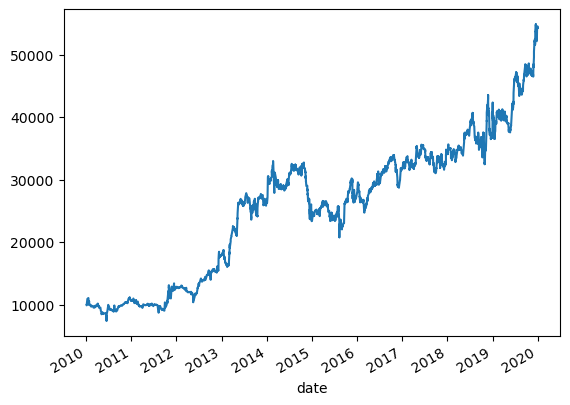

In [88]:
bband_strategy.get_transaction_history()['total_value'].plot()

## Out Sample Test

In [90]:
bband_strategy = backtest_swing_trade(df.loc['2020-01-01':'2024-01-01'], 
                                        'decay_bband', 
                                        0.5,
                                        10,
                                        take_profit=0.20, 
                                        cut_loss=0.05, 
                                        minimum_adv=1e6,
                                        max_holdings_days = 5,
                                        budget=5000,
                                        initial_cash=10000)
bband_strategy.summarize()

,portfolio_values_first_trade,portfolio_values_last_trade,average_return,lowest_return,portfolio_return
date,,,,,
2020,9770.465540,14049.788407,0.003761,-0.050000,0.437986
2021,14055.023575,14720.402664,0.004368,-0.050000,0.047341
2022,14542.452834,8539.617729,-0.010856,-0.050000,-0.412780
2023,8288.860316,9015.642000,0.001706,-0.051852,0.087682


<Axes: xlabel='date'>

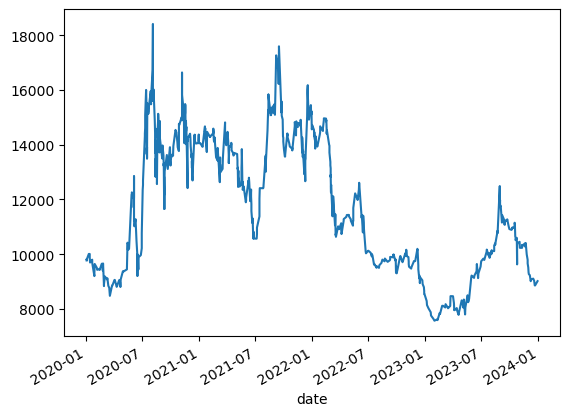

In [91]:
bband_strategy.get_transaction_history()['total_value'].plot()